In [132]:
using DataFrames
using HDF5
using Statistics: mean
using StatsPlots
using Plots
using Measures

datasets = [
    "/store/DAMTPEGLEN/mw894/data/Charlesworth2015/ctx",
    "/store/DAMTPEGLEN/mw894/data/Charlesworth2015/hpc",
    "/store/DAMTPEGLEN/mw894/data/Demas2006",
    "/store/DAMTPEGLEN/mw894/data/Maccione2014",
]

4-element Array{String,1}:
 "/store/DAMTPEGLEN/mw894/data/Charlesworth2015/ctx"
 "/store/DAMTPEGLEN/mw894/data/Charlesworth2015/hpc"
 "/store/DAMTPEGLEN/mw894/data/Demas2006"
 "/store/DAMTPEGLEN/mw894/data/Maccione2014"

## General data collector

In [133]:
df1 = DataFrame(
    dset_name=String[],
    sample_name=String[],
    org_file_name=String[],
    div=Int[],
    mean_firing_rate=Float64[]
)

for p_dir in datasets
    # get 
    dset_name = replace(p_dir, "/store/DAMTPEGLEN/mw894/data/" => "")

    # get files
    recording_files = filter(file -> endswith(file, ".h5") && startswith(file, "sample_"), readdir(p_dir))

    # start with sample and h5 extension
    for sample_name in recording_files
        # read in the age
        file = h5open(joinpath(p_dir, sample_name), "r")
        div = read(file, "meta/age")[1]
        org_file_name = read(file, "meta/org_file_name")
        avg_firing_rate = mean(read(file, "/summary/frate"))
        close(file)

        # remove extension
        sample_name = replace(sample_name, ".h5" => "")

        # add row
        push!(df1, (dset_name, sample_name, org_file_name, div, avg_firing_rate))
    end
end

In [134]:
df2 = DataFrame(
    org_file_name=String[],
    density=Float64[]
)

for p_dir in datasets
    # get 
    dset_name = replace(p_dir, "/store/DAMTPEGLEN/mw894/data/" => "")

    # get files
    recording_files = filter(file -> endswith(file, ".dat") && startswith(file, "sample_"), readdir(p_dir))

    # start with sample and h5 extension
    for sample_name in recording_files
        # read in the age
        file = h5open(joinpath(p_dir, sample_name), "r")
        meta_group = file["meta"]
        model_id = read_attribute(meta_group, "model_id")
        org_file_name = read_attribute(meta_group, "org_file_name")
        A_Y = read(file, "A_Y")
        close(file)

        # Only need to consider once
        if model_id != 1
            continue
        end

        # remove extension
        sample_name = replace(sample_name, ".dat" => "")

        # compute density
        density = (sum(A_Y) / 2) / ((size(A_Y, 1) * (size(A_Y, 1) - 1)) / 2)

        # add row
        push!(df2, ( org_file_name, density))
    end
end

In [135]:
size(df2), size(df1)

((576, 2), (676, 5))

In [136]:
df = leftjoin(df1, df2,on=[:org_file_name])
df.week = ceil.(Int, df.div / 7)
replace!(df.week, 5 => 4)

676-element Array{Int64,1}:
 1
 1
 1
 2
 2
 2
 2
 2
 2
 2
 ⋮
 2
 2
 2
 2
 2
 2
 2
 1
 2

## Number of samples at each div

In [137]:
# 1. Number of sampels at each div
sample_age = combine(groupby(df, [:dset_name, :div]), nrow => :Count)
sample_age = sort(sample_age, :div)
sample_age

,dset_name,div,Count
,String,Int64,Int64
1,Maccione2014,2,1
2,Maccione2014,3,2
3,Maccione2014,4,4
4,Maccione2014,5,4
5,Maccione2014,6,6
6,Charlesworth2015/ctx,7,32
7,Charlesworth2015/hpc,7,57
8,Demas2006,7,10
9,Maccione2014,7,2


## Firing frequency at DIV

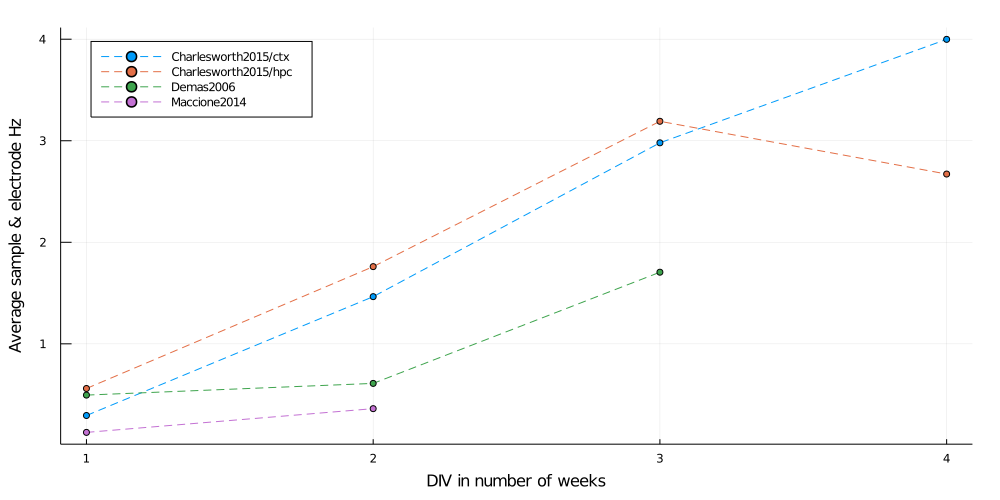

In [138]:
firing_rate = combine(groupby(df, [:dset_name, :week]), :mean_firing_rate => mean => :mean_mean_firing_rate)
firing_rate_groups = groupby(firing_rate, :dset_name)

plot_firing_rates = Array{Float64}[]
plot_weeks = Array{Float64}[]
labels = String[]

for (dset_name, sub_df) in pairs(firing_rate_groups)
    ordered_sub_firing_rates = zeros(maximum(firing_rate.week))

    sub_firing_rates = sub_df[:,:mean_mean_firing_rate]
    sub_weeks = sub_df[:,:week]

    # sort by time
    sorted_perm = sortperm(sub_weeks)
    sub_weeks = sub_weeks[sorted_perm]
    sub_firing_rates = sub_firing_rates[sorted_perm]

    # append to collectors
    push!(plot_firing_rates, sub_firing_rates)
    push!(plot_weeks, sub_weeks)
    push!(labels, dset_name[1])
end

p = plot(
    plot_weeks, 
    plot_firing_rates, 
    label=reshape(labels, (1,4)), 
    legend=:topleft, 
    marker = :circle, 
    linestyle=:dash,
    size = (1000, 500),
    margin=5mm
    )
xlabel!("DIV in number of weeks")
ylabel!("Average sample & electrode Hz")
savefig(p, "firing_rates.pdf")
display(p)

## Connection density

In [139]:
connection_dens_groups = groupby(df, :dset_name)

plots = []
labels = []
for (i,dset_name) in enumerate(unique(df.dset_name))
    sub_df = filter(:dset_name => x -> x == dset_name, df)
    sub_df = filter(:density => !ismissing, sub_df)
    sub_df = sub_df[!, [:week, :density]]

    for i in 1:4
        if !(i in sub_df.week)
           push!(sub_df, (i, 0))
        end
    end

    p = @df sub_df boxplot(:week, :density, fillalpha=0.75, linewidth=2, legend=false, color=palette(:default)[i])
    xlabel!("DIV in number of weeks")
    ylabel!("Connection density")
    push!(plots, p)
    push!(labels, dset_name)
end

p = plot(plots..., layout=4, size=(1500, 1500), title=reshape(labels, (1,4)), margin=5mm)
savefig(p, "connection_densities.pdf")